### Processing Echosounder Data from Ocean Observatories Initiative with `echopype`.

Downloading a file from the OOI website. We pick August 21, 2017 since this was the day of the solar eclipse which affected the traditional patterns of the marine life.

In [44]:
# downloading the file
!wget https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/OOI-D20170821-T163049.raw 

--2019-02-18 10:54:47--  https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/OOI-D20170821-T163049.raw
Resolving rawdata.oceanobservatories.org (rawdata.oceanobservatories.org)... 128.6.240.153
Connecting to rawdata.oceanobservatories.org (rawdata.oceanobservatories.org)|128.6.240.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52431936 (50M) [text/plain]
Saving to: ‘OOI-D20170821-T163049.raw’

OOI-D20170821-T1630 100%[===================>]  50.00M  19.5MB/s    in 2.6s    

2019-02-18 10:54:50 (19.5 MB/s) - ‘OOI-D20170821-T163049.raw’ saved [52431936/52431936]



In [46]:
filename = 'OOI-D20170821-T163049.raw'

**Converting from Raw to Standartized Netcdf Format**

In [47]:
# import as part of a submodule
from echopype.convert import ConvertEK60
data_tmp = ConvertEK60(filename)
data_tmp.raw2nc()
os.remove(filename)

10:55:03  converting file: OOI-D20170821-T163049.raw


**Calibrating, Denoising, Mean Volume Backscatter Strength**

In [48]:
from echopype.model import EchoData
data = EchoData(filename[:-4]+'.nc')
data.calibrate()  # Calibration and echo-integration
data.remove_noise(save=True)  # Save denoised Sv to FILENAME_Sv_clean.nc
data.get_MVBS(save=True)

10:55:08  saving calibrated Sv to OOI-D20170821-T163049_Sv.nc
10:55:19  saving denoised Sv to OOI-D20170821-T163049_Sv_clean.nc
10:55:20  saving MVBS to OOI-D20170821-T163049_MVBS.nc


**Visualizing the Result**

In [49]:
%matplotlib inline

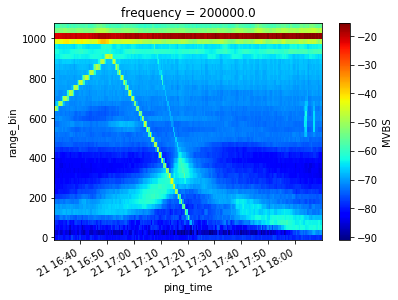

In [51]:
data.MVBS.MVBS.sel(frequency=200000).plot(x='ping_time',cmap = 'jet')

**Processing Multiple Files**

To process multiple file from the OOI website we need to scrape the names of the existing files there. We will use the `Beautiful Soup`
package for that. 

In [ ]:
!conda install --yes beautifulsoup4

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [2]:
path = 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/'

In [3]:
response = urlopen(path)
soup = BeautifulSoup(response.read(), "html.parser")

In [4]:
# urls = []
# for item in soup.find_all(text=True):
#    if '.raw' in item:
#        urls.append(path+'/'+item)        

In [5]:
urls = [path+'/'+item for item in soup.find_all(text=True) if '.raw' in item]

In [6]:
# urls

In [7]:
from datetime import datetime

Specify range:

In [8]:
start_time = '20170821-T000000'
end_time = '20170822-T235959'

In [9]:
# convert the times to datetime format
start_datetime = datetime.strptime(start_time,'%Y%m%d-T%H%M%S')
end_datetime = datetime.strptime(end_time,'%Y%m%d-T%H%M%S')

In [10]:
# function to check if a date is in the date range
def in_range(date_str, start_time, end_time):
    date_str = datetime.strptime(date_str,'%Y%m%d-T%H%M%S')
    true = date_str >= start_datetime and date_str <= end_datetime
    return(true)
    

In [11]:
# identify the list of urls in range
range_urls = []
for url in urls: 
    date_str = url[-20:-4]
    if in_range(date_str, start_time, end_time):
        range_urls.append(url)
        

In [ ]:
range_urls

In [13]:
rawnames = [url.split('//')[-1] for url in range_urls]

In [ ]:
ls

In [15]:
import os

**Downloading the Files**

In [16]:
# Download the files
import requests
rawnames = []
for url in range_urls:
    r = requests.get(url, allow_redirects=True)
    rawnames.append(url.split('//')[-1])
    open(url.split('//')[-1], 'wb').write(r.content)

In [17]:
!pip install echopype
    

In [ ]:
ls

**Converting from Raw to Standartized Netcdf Format**

In [ ]:
# import as part of a submodule
from echopype.convert import ConvertEK60
for filename in rawnames:
    data_tmp = ConvertEK60(filename)
    data_tmp.raw2nc()
    os.remove(filename)

In [20]:
#ls

**Calibrating, Denoising, Mean Volume Backscatter Strength**

In [ ]:
# calibrate and denoise
from echopype.model import EchoData

for filename in rawnames:

    data = EchoData(filename[:-4]+'.nc')
    data.calibrate()  # Calibration and echo-integration
    data.remove_noise(save=False)  # Save denoised Sv to FILENAME_Sv_clean.nc
    data.get_MVBS(save=True)
    os.remove(filename[:-4]+'.nc')
    os.remove(filename[:-4]+'_Sv.nc')

**Opening and Visualizing the Results in Parallel**

No that all files are in an appropriate format, we can open them and visualize them in parallel. For that we will need to install the `dask` parallelization library.

In [22]:
!conda install --yes dask

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.4

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [23]:
import xarray as xr

In [24]:
res = xr.open_mfdataset('*MVBS.nc')

In [25]:
import matplotlib.pyplot as plt

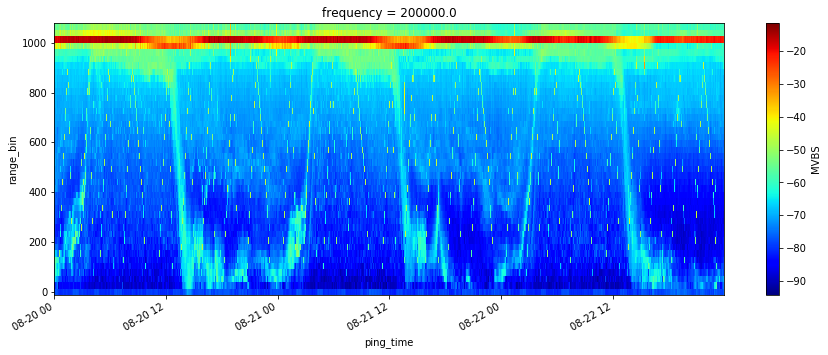

In [26]:
plt.figure(figsize = (15,5))
res.MVBS.sel(frequency=200000).plot(x='ping_time',cmap = 'jet')